# 4 Advanced Modeling - Specialized Packages

In this notebook we will use more advanced models on our two wells to see if we can further improve the MAPE scores compared to our base models. We will be using the following packages Auto -ARIMA, KATS, SKTIME and Silverkite.

## TABLE OF CONTENTS:
* [4.1 Import Relevant Package](#1)
* [4.2 Import CSV](#2)
* [4.3 Examine Data](#3)
* [4.4 Preprocessing and training for well with a typical decline curve profile](#4)
    * [4.4.1 Auto-ARIMA](#5)
    * [4.4.2 KATS](#6)
        * [4.4.2.1 KATS - ARIMA](#7)
        * [4.4.2.2 KATS - fbProphet](#8)
        * [4.4.2.3 KATS - Theta model](#9)
        * [4.4.2.4 KATS - Harmonic Regression model](#10)
        * [4.4.2.5 KATS - LSTM model](#11)
        * [4.4.2.6 KATS - Ensemble model](#12)
    * [4.4.3 SKTIME](#13)
        * [4.4.3.1 SKTIME-Theta model](#14)
        * [4.4.3.2 SKTIME-TBATS](#15)
        * [4.4.3.3 SKTIME-Polynomial Trend](#16)
    * [4.4.4 Silverkite](#17)
    * [4.4.5 Performance of Models](#18)
* [4.5 Preprocessing and training for well with a typical decline curve profile](#19)
    * [4.5.1 Auto-ARIMA](#20)
    * [4.5.2 KATS](#21)
        * [4.5.2.1 KATS - ARIMA](#22)
        * [4.5.2.2 KATS - fbProphet](#23)
        * [4.5.2.3 KATS - Theta model](#24)
        * [4.5.2.4 KATS - Harmonic Regression model](#25)
        * [4.5.2.5 KATS - LSTM model](#26)
        * [4.5.2.6 KATS - Ensemble model](#27)
    * [4.5.3 SKTIME](#28)
        * [4.5.3.1 SKTIME-Theta model](#29)
        * [4.5.3.2 SKTIME-TBATS](#30)
        * [4.5.3.3 SKTIME-Polynomial Trend](#31)
    * [4.5.4 Silverkite](#32)
    * [4.5.5 Performance of Models](#33)
* [4.6 Summary](#34) 
        
            
        
            
            
            
            
            
            
        
            
            
            
            
        




 <b>4.1 Import Relevant Package <b/> <a class="anchor" id="1"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima.arima import auto_arima
from kats.consts import TimeSeriesData
from kats.models.sarima import SARIMAModel, SARIMAParams
from kats.models.prophet import ProphetModel, ProphetParams
from kats.models.theta import ThetaModel, ThetaParams
from kats.models.quadratic_model import QuadraticModel, QuadraticModelParams
from kats.models.lstm import LSTMModel, LSTMParams
import warnings as warnings
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import ( arima, holtwinters,linear_model,prophet, quadratic_model,sarima,theta)
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.trend import PolynomialTrendForecaster
import plotly
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster


 <b>4.2 Import CSV <b/> <a class="anchor" id="2"></a>

Import relevant csv files (Monthly data and model performance summary data for each well from the last notebook).

In [2]:
df = pd.read_csv('Monthly.csv')
PerformanceB1 = pd.read_csv('df1Performance.csv')
PerformanceB2 = pd.read_csv('df2Performance.csv')

In [3]:
PerformanceB1.rename(columns={'Unnamed: 0': 'Model'},inplace=True)
PerformanceB2.rename(columns={'Unnamed: 0': 'Model'},inplace=True)

 <b>4.3 Examine Data <b/>  <a class="anchor" id="3"></a>

Drop index and level_0 columns

In [4]:
df.drop(columns=['index','level_0'], inplace=True)

Call head of data.

In [5]:
df.head(2)

,DATEPRD,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,...,AVG_DP_TUBING.shifted3,AVG_ANNULUS_PRESS.shifted3,AVG_CHOKE_SIZE_P.shifted3,AVG_WHP_P.shifted3,AVG_WHT_P.shifted3,DP_CHOKE_SIZE.shifted3,BORE_OIL_VOL.shifted3,BORE_GAS_VOL.shifted3,BORE_WAT_VOL.shifted3,BORE_WI_VOL.shifted3
0,2014-07-01,215.305839,108.150677,166.458710,0.0,47.269826,48.847129,56.742968,20.381968,15084.0,...,211.228320,0.0,22.489461,47.242292,27.762750,34.311375,631.0,0.0,0.0,0.0
1,2014-08-01,230.622097,105.879581,188.180742,0.0,29.241656,42.441258,41.679613,24.964645,6968.0,...,155.976129,0.0,46.416057,67.994387,55.577839,39.485194,20569.0,0.0,783.0,0.0


Make 'DATEPRD' as index

In [6]:
df.set_index('DATEPRD',inplace=True)

Call head of data.

In [7]:
df.head(2)

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,...,AVG_DP_TUBING.shifted3,AVG_ANNULUS_PRESS.shifted3,AVG_CHOKE_SIZE_P.shifted3,AVG_WHP_P.shifted3,AVG_WHT_P.shifted3,DP_CHOKE_SIZE.shifted3,BORE_OIL_VOL.shifted3,BORE_GAS_VOL.shifted3,BORE_WAT_VOL.shifted3,BORE_WI_VOL.shifted3
DATEPRD,,,,,,,,,,,,,,,,,,,,,
2014-07-01,215.305839,108.150677,166.458710,0.0,47.269826,48.847129,56.742968,20.381968,15084.0,0.0,...,211.228320,0.0,22.489461,47.242292,27.762750,34.311375,631.0,0.0,0.0,0.0
2014-08-01,230.622097,105.879581,188.180742,0.0,29.241656,42.441258,41.679613,24.964645,6968.0,0.0,...,155.976129,0.0,46.416057,67.994387,55.577839,39.485194,20569.0,0.0,783.0,0.0


Convert index to datetime

In [8]:
df.index = pd.to_datetime(df.index)

Call shape of dataframe

In [9]:
df.shape

(285, 25)

Call column names

In [10]:
df.columns

Index(['AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING',
       'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P',
       'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL',
       'BORE_WI_VOL', 'NPD_WELL_BORE_NAME', 'AVG_DOWNHOLE_PRESSURE.shifted3',
       'AVG_DOWNHOLE_TEMPERATURE.shifted3', 'AVG_DP_TUBING.shifted3',
       'AVG_ANNULUS_PRESS.shifted3', 'AVG_CHOKE_SIZE_P.shifted3',
       'AVG_WHP_P.shifted3', 'AVG_WHT_P.shifted3', 'DP_CHOKE_SIZE.shifted3',
       'BORE_OIL_VOL.shifted3', 'BORE_GAS_VOL.shifted3',
       'BORE_WAT_VOL.shifted3', 'BORE_WI_VOL.shifted3'],
      dtype='object')

Create a list of all columns to remove

In [11]:
list_to_remove = ['AVG_DOWNHOLE_PRESSURE.shifted3',
 'AVG_DOWNHOLE_TEMPERATURE.shifted3',
 'AVG_DP_TUBING.shifted3',
 'AVG_ANNULUS_PRESS.shifted3',
 'AVG_CHOKE_SIZE_P.shifted3',
 'AVG_WHP_P.shifted3',
 'AVG_WHT_P.shifted3',
 'DP_CHOKE_SIZE.shifted3',
 'BORE_OIL_VOL.shifted3',
 'BORE_GAS_VOL.shifted3',
 'BORE_WAT_VOL.shifted3',
 'BORE_WI_VOL.shifted3','BORE_WI_VOL']

Drop all unwanted columns.

In [12]:
df.drop(columns=list_to_remove,inplace=True)

Call head of dataframe.

In [13]:
df.head(2)

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,NPD_WELL_BORE_NAME
DATEPRD,,,,,,,,,,,,
2014-07-01,215.305839,108.150677,166.458710,0.0,47.269826,48.847129,56.742968,20.381968,15084.0,0.0,6244.0,15/9-F-1 C
2014-08-01,230.622097,105.879581,188.180742,0.0,29.241656,42.441258,41.679613,24.964645,6968.0,0.0,4530.0,15/9-F-1 C


Call tail of dataframe

In [14]:
df.tail()

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,NPD_WELL_BORE_NAME
DATEPRD,,,,,,,,,,,,
2016-03-01,218.160839,105.842548,184.348968,16.219032,12.305040,33.811903,37.630516,17.960387,3746.0,0.0,5035.0,15/9-F-15 D
2016-04-01,232.432300,105.733967,197.541600,16.938367,19.377015,34.890833,36.453000,11.502967,4545.0,29.0,5687.0,15/9-F-15 D
2016-05-01,209.717903,106.244226,184.899968,18.447258,16.015713,24.818000,42.118097,7.889194,4696.0,0.0,6007.0,15/9-F-15 D
2016-06-01,212.926967,105.923067,184.994100,16.132400,23.024772,27.932900,40.764933,14.086767,3466.0,0.0,5390.0,15/9-F-15 D
2016-07-01,308.101258,92.706710,299.597355,4.271226,7.057121,8.503903,12.570806,9.004000,828.0,0.0,1173.0,15/9-F-15 D


 <b>4.4 Preprocessing and training for well with a typical decline curve profile<b/> <a class="anchor" id="4"></a>

Create dataframe df1 for F-14 well.

In [15]:
df1 = df[df['NPD_WELL_BORE_NAME'] =='15/9-F-14'].copy()

Plot oil production rate

<AxesSubplot:title={'center':'15/9-F-14'}, xlabel='DATEPRD', ylabel='BORE_OIL_VOL'>

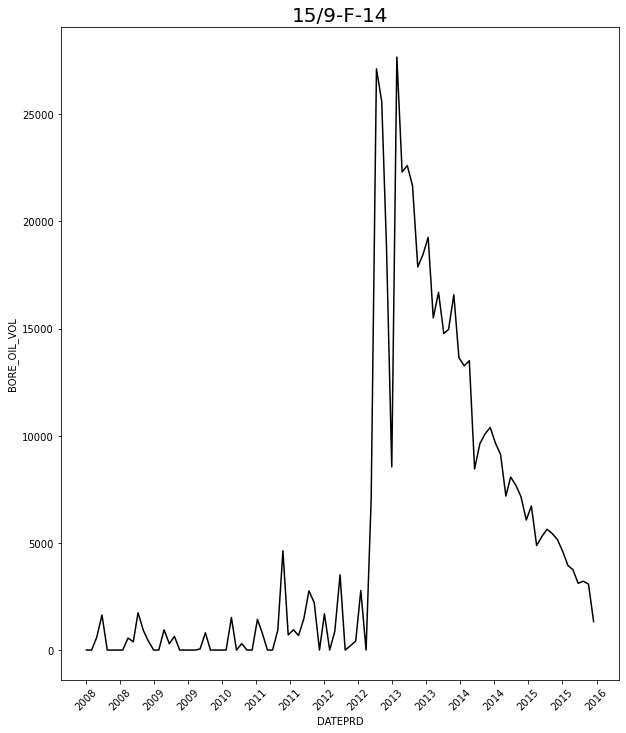

In [16]:
%matplotlib inline
fig_dims = (10, 12)
fig, ax = plt.subplots(figsize=fig_dims)
ax.set_title('15/9-F-14',size=20)
plt.xticks(rotation = 45)
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
sns.lineplot(x='DATEPRD', y='BORE_OIL_VOL', data=df1, ax=ax, color='black')

Remove irrelevant data

In [17]:
df1= df1[df1.index >= '2013-02-01'].copy()

Plot oil production rate

<AxesSubplot:title={'center':'15/9-F-14'}, xlabel='DATEPRD', ylabel='BORE_OIL_VOL'>

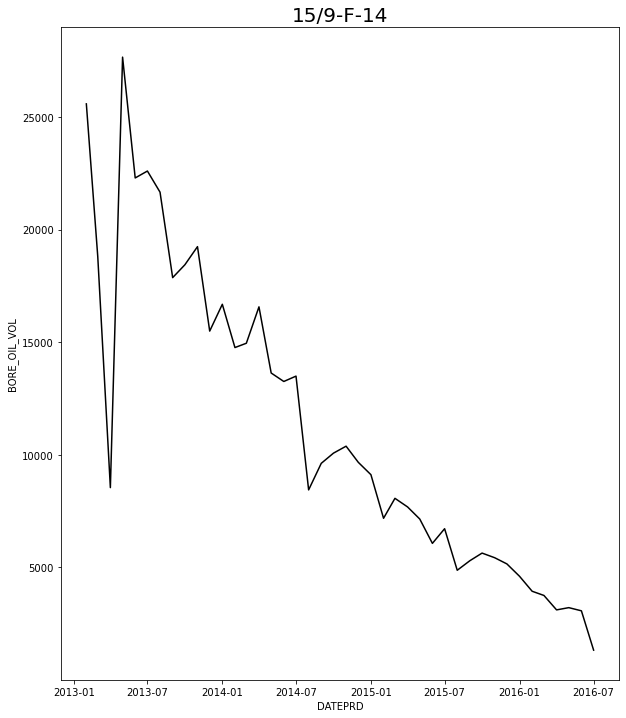

In [18]:
fig_dims = (10, 12)
fig, ax = plt.subplots(figsize=fig_dims)
ax.set_title('15/9-F-14',size=20)
sns.lineplot(x='DATEPRD', y='BORE_OIL_VOL', data=df1, ax=ax, color='black')

Examine dataframe shape.

In [19]:
df1.shape

(42, 12)

Call dataframe head.

In [20]:
df1.head()

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,NPD_WELL_BORE_NAME
DATEPRD,,,,,,,,,,,,
2013-02-01,242.421357,101.094214,209.964714,22.047036,96.248736,32.456643,87.408179,3.390214,25589.0,0.0,0.0,15/9-F-14
2013-03-01,245.233805,100.381593,208.418654,19.721192,61.694085,36.922413,81.552552,9.453654,18818.0,0.0,348.0,15/9-F-14
2013-04-01,244.286854,100.123739,206.884745,19.660531,60.121212,37.550047,82.163571,10.099634,8545.0,0.0,393.0,15/9-F-14
2013-05-01,238.605935,98.639355,206.072645,22.351516,97.713162,32.533387,87.742226,3.551355,27665.0,0.0,0.0,15/9-F-14
2013-06-01,244.610010,100.419686,211.495473,20.558532,85.809295,33.188373,87.409936,4.456317,22299.0,0.0,385.0,15/9-F-14


Call dataframe tail

In [21]:
df1.tail()

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,NPD_WELL_BORE_NAME
DATEPRD,,,,,,,,,,,,
2016-03-01,267.556452,99.625387,239.260194,21.033677,98.741093,28.296194,88.031548,1.885323,3755.0,0.0,0.0,15/9-F-14
2016-04-01,268.142267,99.594733,239.015767,22.148467,83.716599,29.126433,87.600967,3.120167,3114.0,0.0,0.0,15/9-F-14
2016-05-01,270.780226,99.769323,239.268000,22.514065,42.852574,31.512226,87.651548,5.693258,3214.0,0.0,0.0,15/9-F-14
2016-06-01,269.827700,100.053033,238.942100,23.435200,47.767466,30.885567,88.542800,5.303067,3073.0,0.0,0.0,15/9-F-14
2016-07-01,286.916323,98.268194,259.612484,12.011452,29.669248,27.303903,41.712613,7.113097,1326.0,0.0,0.0,15/9-F-14


 <b>4.4.1 Auto-ARIMA<b/> <a class="anchor" id="5"></a>

Create oil production rate time series

In [22]:
df1_Oil = df1['BORE_OIL_VOL']

Call time series tail

In [23]:
df1_Oil.tail()

DATEPRD
2016-03-01    3755.0
2016-04-01    3114.0
2016-05-01    3214.0
2016-06-01    3073.0
2016-07-01    1326.0
Name: BORE_OIL_VOL, dtype: float64

Split time series between Training and Testing

In [24]:
Train=df1_Oil.loc[:'2016-03-01']

In [25]:
Test=df1_Oil.loc['2016-04-01':]

In [26]:
Test

DATEPRD
2016-04-01    3114.0
2016-05-01    3214.0
2016-06-01    3073.0
2016-07-01    1326.0
Name: BORE_OIL_VOL, dtype: float64

Plot train set.

<AxesSubplot:xlabel='DATEPRD'>

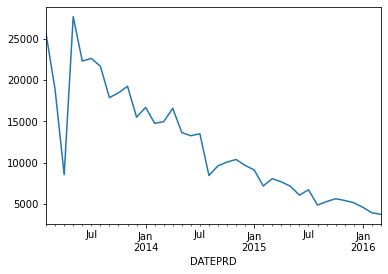

In [27]:
Train.plot() 

Plot test set.

<AxesSubplot:xlabel='DATEPRD'>

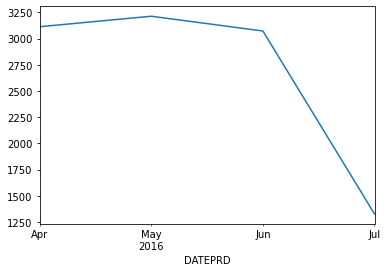

In [28]:
Test.plot()

Create auto arima object. This model will auto-select the best model given our p , q , d space  and select the model with the lowest AIC score.

In [29]:
arima_model = auto_arima(Train, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=4, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None)

Print summary of auto-ARIMA model

In [30]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   38
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -340.110
Date:                Thu, 07 Apr 2022   AIC                            690.219
Time:                        22:26:59   BIC                            698.274
Sample:                             0   HQIC                           693.059
                                 - 38                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -792.0638    889.779     -0.890      0.373   -2535.999     951.871
ar.L1         -0.9654      0.083    -11.594      0.000      -1.129      -0.802
ar.L2         -0.6063      0.036    -16.953      0.000      -0.676      -0.536
ma.L1          0.4863      0.216      2.252      0.024       0.063       0.910
sigma2      5.797e+06      0.176   3.29e+07      0.000     5.8e+06     5.8e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 9.47
Prob(Q):                              0.81   Prob(JB):                         0.01
Heteroskedasticity (H):               0.04   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.7e+23. Standard errors may be unstable.
"""

The best Auto-ARIMA model does not have the same p,d,q as the auto-ARIMA model.

Create Summary dataframe

In [31]:
Summary =pd.DataFrame(Test)

Call summary dataframe

In [32]:
Summary

,BORE_OIL_VOL
DATEPRD,
2016-04-01,3114.0
2016-05-01,3214.0
2016-06-01,3073.0
2016-07-01,1326.0


Add auto-ARIMA predictions for the next 4 months to the Summary dataframe.

In [33]:
Summary['Auto-ARIMA'] =pd.DataFrame(arima_model.predict(n_periods=4),index=Test.index)

Call summary dataframe

In [34]:
Summary

,BORE_OIL_VOL,Auto-ARIMA
DATEPRD,,
2016-04-01,3114.0,3484.921997
2016-05-01,3214.0,3066.976457
2016-06-01,3073.0,2842.155978
2016-07-01,1326.0,2520.542813


 <b>4.4.2 KATS<b/> <a class="anchor" id="6"></a>

KATS which stands for Kits to Analyze Time Series is a light-weight,easy-to-use,extenable, and generalizable framework to perform time series analysis in Python. It supports forecasting, detection, feature extractionand useful utilites such as time series simulators. KATS supports the following 10 forecasting models Linear, Quadratic, ARIMA, SARIMA, Holt-Winters, Prophet, AR-Net, LSTM, Theta and VAR. 

 <b>4.4.2.1 KATS - ARIMA<b/> <a class="anchor" id="7"></a>

KATS has an ARIMA implementation and we will use this as our first model.

Call shape of dataframe

In [35]:
df1.shape

(42, 12)

Create training set by removing last 4 months of data

In [36]:
df1_train = df1.loc[:'2016-03-01'].copy()

Call shape of dataframe

In [37]:
df1_train.shape

(38, 12)

Call head of dataframe

In [38]:
df1_train.head()

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,NPD_WELL_BORE_NAME
DATEPRD,,,,,,,,,,,,
2013-02-01,242.421357,101.094214,209.964714,22.047036,96.248736,32.456643,87.408179,3.390214,25589.0,0.0,0.0,15/9-F-14
2013-03-01,245.233805,100.381593,208.418654,19.721192,61.694085,36.922413,81.552552,9.453654,18818.0,0.0,348.0,15/9-F-14
2013-04-01,244.286854,100.123739,206.884745,19.660531,60.121212,37.550047,82.163571,10.099634,8545.0,0.0,393.0,15/9-F-14
2013-05-01,238.605935,98.639355,206.072645,22.351516,97.713162,32.533387,87.742226,3.551355,27665.0,0.0,0.0,15/9-F-14
2013-06-01,244.610010,100.419686,211.495473,20.558532,85.809295,33.188373,87.409936,4.456317,22299.0,0.0,385.0,15/9-F-14


Drop 'NPD_WELL_BORE_NAME' column.

In [39]:
df1_train.drop(columns=['NPD_WELL_BORE_NAME'],inplace=True)

Create TimeSeriesData object by assigning index as time value and oil production rate as value. 

In [40]:
DF1 =TimeSeriesData(time=df1_train.index,value=df1_train['BORE_OIL_VOL'])

Create SARIMA param class

In [41]:
params = SARIMAParams(
    p = 3, 
    d=1, 
    q=0, 
    )

Initiate SARIMA model

In [42]:
m = SARIMAModel(data=DF1, params=params)

Fit SARIMA model

In [43]:
m.fit()

Generate Forecast values

In [44]:
fcst = m.predict(
    steps=4, 
    freq="MS"
    )

In [45]:
fcst

,time,fcst,fcst_lower,fcst_upper
38,2016-04-01,3890.420335,-1025.464392,8806.305062
39,2016-05-01,3707.514647,-1839.047674,9254.076968
40,2016-06-01,3708.663700,-2297.945194,9715.272593
41,2016-07-01,3794.409902,-3624.994891,11213.814695


Save Forecast values to Summary dataframe

In [46]:
Summary['KATS-ARIMAX'] =list(fcst['fcst'])

Print Forecast values

In [47]:
fcst

,time,fcst,fcst_lower,fcst_upper
38,2016-04-01,3890.420335,-1025.464392,8806.305062
39,2016-05-01,3707.514647,-1839.047674,9254.076968
40,2016-06-01,3708.663700,-2297.945194,9715.272593
41,2016-07-01,3794.409902,-3624.994891,11213.814695


Print Summary dataframe

In [48]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX
DATEPRD,,,
2016-04-01,3114.0,3484.921997,3890.420335
2016-05-01,3214.0,3066.976457,3707.514647
2016-06-01,3073.0,2842.155978,3708.663700
2016-07-01,1326.0,2520.542813,3794.409902


<b>4.4.2.2 KATS - fbProphet<b/> <a class="anchor" id="8"></a>

Create Prophetparams class model

In [49]:
params = ProphetParams()

Create a prophet model instance

In [50]:
m = ProphetModel(DF1, params)

Fit fbProphet model

In [51]:
m.fit()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Generate Forecast values

In [52]:
fcst = m.predict(
    steps=4, 
    freq="MS"
    )

Print Forecast values

In [53]:
fcst

,time,fcst,fcst_lower,fcst_upper
0,2016-04-01,-13366.501908,-15692.223151,-11121.534415
1,2016-05-01,9987.076614,7711.674317,12170.001720
2,2016-06-01,2353.400366,120.563691,4440.454122
3,2016-07-01,1754.013981,-591.226424,3954.615633


Save Forecast values to Summary dataframe

In [54]:
Summary['KATS-fbProphet'] =list(fcst['fcst'])

Print Summary dataframe

In [55]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX,KATS-fbProphet
DATEPRD,,,,
2016-04-01,3114.0,3484.921997,3890.420335,-13366.501908
2016-05-01,3214.0,3066.976457,3707.514647,9987.076614
2016-06-01,3073.0,2842.155978,3708.663700,2353.400366
2016-07-01,1326.0,2520.542813,3794.409902,1754.013981


Plot timeseries training set and predictions

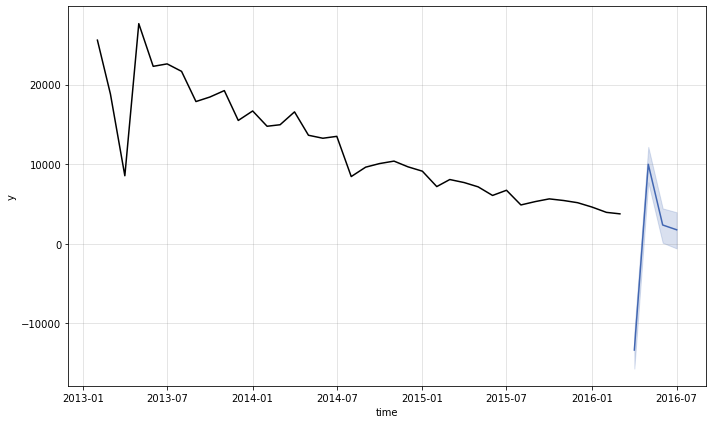

In [56]:
m.plot()

The model predicted a negative value for the first value which is physically impossible.

<b>4.4.2.3 KATS - Theta model<b/> <a class="anchor" id="9"></a>

The theta model is a simple exponential smoothing model with drift.

Create Thetaparams class model

In [57]:
params = ThetaParams()

Create a Theta model instance

In [58]:
m = ThetaModel(data=DF1, params=params)

Fit Theta model

In [59]:
m.fit()

C:\Users\ferna\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\kats\models\theta.py:121: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



Generate Forecast values

In [60]:
fcst = m.predict(
    steps=4, 
    freq="MS"
    )

Print Forecast values

In [61]:
fcst

,time,fcst,fcst_lower,fcst_upper
38,2016-04-01,3560.549253,-3512.152766,10633.251273
39,2016-05-01,3293.772144,-4707.921544,11295.465832
40,2016-06-01,3026.995035,-5806.525775,11860.515845
41,2016-07-01,2760.217926,-6833.273509,12353.709361


Save Forecast values to Summary dataframe

In [62]:
Summary['KATS-Theta'] =list(fcst['fcst'])

Print Summary dataframe

In [63]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX,KATS-fbProphet,KATS-Theta
DATEPRD,,,,,
2016-04-01,3114.0,3484.921997,3890.420335,-13366.501908,3560.549253
2016-05-01,3214.0,3066.976457,3707.514647,9987.076614,3293.772144
2016-06-01,3073.0,2842.155978,3708.663700,2353.400366,3026.995035
2016-07-01,1326.0,2520.542813,3794.409902,1754.013981,2760.217926


Plot timeseries training set and predictions

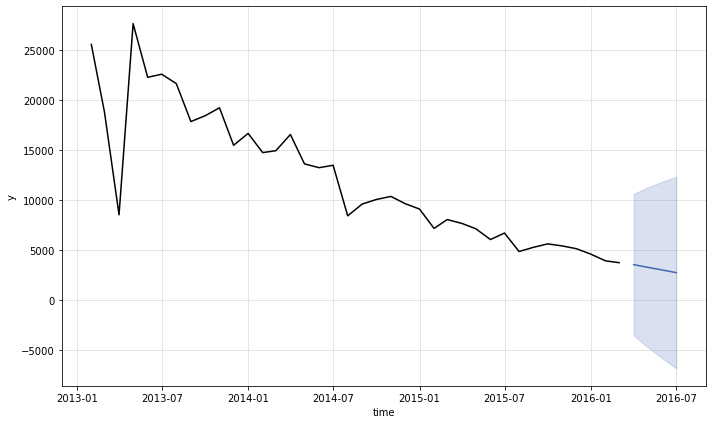

In [64]:
m.plot()

<b>4.4.2.4 KATS - Harmonic Regression model<b/> <a class="anchor" id="10"></a>
    

Harmonic regression is linear regression with sinusoidal functions to characterize seasonality in a time series.

Create HarmonicRegressionModelParams class model

In [65]:
params = QuadraticModelParams()

Create a Quadratic model instance

In [66]:
m = QuadraticModel(data=DF1, params=params)

Fit Quadratic Model

In [67]:
m.fit()

Generate Forecast values

In [68]:
fcst = m.predict(
    steps=4, 
    freq="MS"
    )

Print Forecast values

In [69]:
fcst

,time,fcst,fcst_lower,fcst_upper
0,2016-04-01,2907.545756,-3687.751630,9502.843143
1,2016-05-01,2557.531677,-4192.062537,9307.125892
2,2016-06-01,2216.694606,-4710.736646,9144.125857
3,2016-07-01,1885.034541,-5244.786072,9014.855153


Save Forecast values to Summary dataframe

In [70]:
Summary['KATS-Quadratic'] =list(fcst['fcst'])

Print Summary dataframe

In [71]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX,KATS-fbProphet,KATS-Theta,KATS-Quadratic
DATEPRD,,,,,,
2016-04-01,3114.0,3484.921997,3890.420335,-13366.501908,3560.549253,2907.545756
2016-05-01,3214.0,3066.976457,3707.514647,9987.076614,3293.772144,2557.531677
2016-06-01,3073.0,2842.155978,3708.663700,2353.400366,3026.995035,2216.694606
2016-07-01,1326.0,2520.542813,3794.409902,1754.013981,2760.217926,1885.034541


Plot timeseries training set and predictions

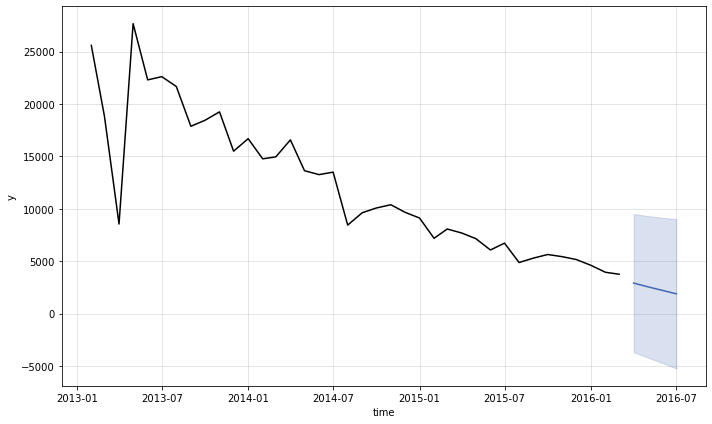

In [72]:
m.plot()

<b>4.4.2.5 KATS - LSTM model<b/> <a class="anchor" id="11"></a>

The LSTM model stands for Long short-term memory, it is a recurrent neural network model that can be used for sequential data.

Create LSTMParams class model

In [73]:
params = LSTMParams(hidden_size=4,time_window=6,num_epochs = 100)

Create an LSTM model instance

In [74]:
m = LSTMModel(data=DF1, params=params)

Fit LSTM model

In [75]:
m.fit()

Generate Forecast values

In [76]:
fcst = m.predict(
    steps=4, 
    freq="MS"
    )

Print Forecast values

In [77]:
fcst

,time,fcst,fcst_lower,fcst_upper
0,2016-04-01,2722.332742,2586.216105,2858.449379
1,2016-05-01,2300.851201,2185.808641,2415.893761
2,2016-06-01,2130.214068,2023.703365,2236.724772
3,2016-07-01,2039.155722,1937.197936,2141.113508


Save Forecast values to Summary dataframe

In [78]:
Summary['KATS-LSTM'] =list(fcst['fcst'])

Print Summary dataframe

In [79]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX,KATS-fbProphet,KATS-Theta,KATS-Quadratic,KATS-LSTM
DATEPRD,,,,,,,
2016-04-01,3114.0,3484.921997,3890.420335,-13366.501908,3560.549253,2907.545756,2722.332742
2016-05-01,3214.0,3066.976457,3707.514647,9987.076614,3293.772144,2557.531677,2300.851201
2016-06-01,3073.0,2842.155978,3708.663700,2353.400366,3026.995035,2216.694606,2130.214068
2016-07-01,1326.0,2520.542813,3794.409902,1754.013981,2760.217926,1885.034541,2039.155722


Plot timeseries training set and predictions

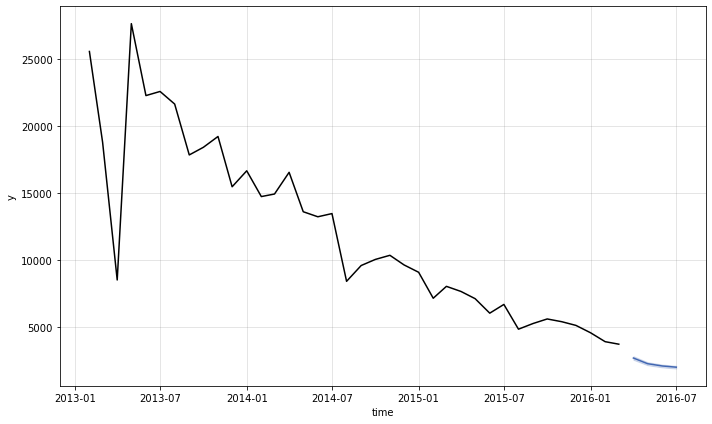

In [80]:
m.plot()

<b>4.4.2.6 KATS - Ensemble model<b/> <a class="anchor" id="12"></a>

The ensemble model in KATS allows us to aggregate different models in KATS. In this model we will combine the prophet, linear, quadratic and theta models and find the median of the models as a forecast.

Define the parameters for each individual forecasting model in 'EnsembleParams' class.

In [81]:
model_params = EnsembleParams(
            [
                                
                BaseModelParams("prophet", prophet.ProphetParams()),  # requires fbprophet be installed
                BaseModelParams("linear", linear_model.LinearModelParams()),
                BaseModelParams("quadratic", quadratic_model.QuadraticModelParams()),
                BaseModelParams("theta", theta.ThetaParams(m=12)),
            ]
        )

Create `KatsEnsembleParam` with detailed configurations

In [82]:
KatsEnsembleParam = {
    "models": model_params,
    "aggregation": "median",
    "seasonality_length": 0,
    "decomposition_method": "multiplicative",
    
}

Create `KatsEnsemble` model

In [83]:
m = KatsEnsemble(
    data=DF1, 
    params=KatsEnsembleParam
    )

Fit model

In [84]:
m.fit()

Generate Forecast values

In [85]:
fcst = m.predict(steps=4)

Aggregate individual model results

In [86]:
m.aggregate()

,time,fcst,fcst_lower,fcst_upper
0,2016-04-01,2311.040303,-4078.112516,8700.193123
1,2016-05-01,2925.651911,-4449.992040,10301.295862
2,2016-06-01,2285.047486,-5148.059295,8012.180314
3,2016-07-01,1819.524261,-5695.140451,7694.047188


Save Forecast values to Summary dataframe

In [87]:
Summary['KATS-Ensemble'] =list(m.aggregate()['fcst'])

Print Summary dataframe

In [88]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX,KATS-fbProphet,KATS-Theta,KATS-Quadratic,KATS-LSTM,KATS-Ensemble
DATEPRD,,,,,,,,
2016-04-01,3114.0,3484.921997,3890.420335,-13366.501908,3560.549253,2907.545756,2722.332742,2311.040303
2016-05-01,3214.0,3066.976457,3707.514647,9987.076614,3293.772144,2557.531677,2300.851201,2925.651911
2016-06-01,3073.0,2842.155978,3708.663700,2353.400366,3026.995035,2216.694606,2130.214068,2285.047486
2016-07-01,1326.0,2520.542813,3794.409902,1754.013981,2760.217926,1885.034541,2039.155722,1819.524261


<b>4.4.3 SKTIME<b/> <a class="anchor" id="13"></a>

SKTIME offers scikit-learn compatible interfaces and model composition tools. It is an open-source Python toolbox for machine learning with time series. Sktime extends the scikit-learn API to time series tasks.  


<b>4.4.3.1 SKTIME-Theta model<b/> <a class="anchor" id="14"></a>

Create timeseries with the datetime index as a column.

In [89]:
df1sktime=df1.reset_index().copy()

Create training data.

In [90]:
Traindf1sktime = df1sktime.loc[:37]

Drop irrelevant columns

In [91]:
Traindf1sktime =Traindf1sktime['BORE_OIL_VOL']

Set series frequency to monthly.

In [92]:
Train.index.freq  = 'MS'

Create an Theta model instance

In [93]:
forecaster=ThetaForecaster()

Fit model

In [94]:
forecaster.fit(Traindf1sktime)

ThetaForecaster()

Generate Forecast values

In [95]:
forecaster.predict(fh=[1,2,3,4])

38    3357.509349
39    3090.732240
40    2823.955131
41    2557.178022
dtype: float64

Save Forecast values to Summary dataframe

In [96]:
Summary['SKTIME-ThetaForecaster'] = list(forecaster.predict(fh=[1,2,3,4]))

Print Summary dataframe

In [97]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX,KATS-fbProphet,KATS-Theta,KATS-Quadratic,KATS-LSTM,KATS-Ensemble,SKTIME-ThetaForecaster
DATEPRD,,,,,,,,,
2016-04-01,3114.0,3484.921997,3890.420335,-13366.501908,3560.549253,2907.545756,2722.332742,2311.040303,3357.509349
2016-05-01,3214.0,3066.976457,3707.514647,9987.076614,3293.772144,2557.531677,2300.851201,2925.651911,3090.732240
2016-06-01,3073.0,2842.155978,3708.663700,2353.400366,3026.995035,2216.694606,2130.214068,2285.047486,2823.955131
2016-07-01,1326.0,2520.542813,3794.409902,1754.013981,2760.217926,1885.034541,2039.155722,1819.524261,2557.178022


<b>4.4.3.2 SKTIME-TBATS<b/> <a class="anchor" id="15"></a>

TBATS stands for "Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal components" takes it root in exponential smooting methods. 

Create an TBATS model instance

In [98]:
forecaster= TBATS()

Fit TBATS model

In [99]:
forecaster.fit(Traindf1sktime)

TBATS()

Generate Forecast values

In [100]:
forecaster.predict(fh=[1,2,3,4])

38    3950.472997
39    3851.693363
40    3755.383665
41    3661.482144
Name: BORE_OIL_VOL, dtype: float64

Save Forecast values to Summary dataframe

In [101]:
Summary['SKTIME-TBATS'] = list(forecaster.predict(fh=[1,2,3,4]))

<b>4.4.3.3 SKTIME-Polynomial Trend<b/> <a class="anchor" id="16"></a>

Polynomial Trend Forecaster, forecast time series with a polynomial trend.

In [102]:
forecaster = PolynomialTrendForecaster(degree=4)

Fit Polynomial Trend model

In [103]:
forecaster.fit(Traindf1sktime)

PolynomialTrendForecaster(degree=4)

Generate Forecast values

In [104]:
forecaster.predict(fh=[1,2,3,4])

38    3298.186986
39    2743.111607
40    2090.265923
41    1322.533287
dtype: float64

Save Forecast values to Summary dataframe

In [105]:
Summary['SKTIME-PolynomialTrend'] = list(forecaster.predict(fh=[1,2,3,4]))

Print Summary dataframe

In [106]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX,KATS-fbProphet,KATS-Theta,KATS-Quadratic,KATS-LSTM,KATS-Ensemble,SKTIME-ThetaForecaster,SKTIME-TBATS,SKTIME-PolynomialTrend
DATEPRD,,,,,,,,,,,
2016-04-01,3114.0,3484.921997,3890.420335,-13366.501908,3560.549253,2907.545756,2722.332742,2311.040303,3357.509349,3950.472997,3298.186986
2016-05-01,3214.0,3066.976457,3707.514647,9987.076614,3293.772144,2557.531677,2300.851201,2925.651911,3090.732240,3851.693363,2743.111607
2016-06-01,3073.0,2842.155978,3708.663700,2353.400366,3026.995035,2216.694606,2130.214068,2285.047486,2823.955131,3755.383665,2090.265923
2016-07-01,1326.0,2520.542813,3794.409902,1754.013981,2760.217926,1885.034541,2039.155722,1819.524261,2557.178022,3661.482144,1322.533287


<b>4.4.4 Silverkite <b/> <a class="anchor" id="17"></a>

The Silverkite algorithm is part of the Greykite package. Silverkite, is highly customizable, with tuning parameters to capture diverse time series characterics. The output is interpretable, allowing visualizations of the trend, seasonality, and other effects, along with their statistical significance.

Create training data for silverkite

In [107]:
TrainSilverkite = df1sktime.iloc[:38].copy()

Specify dataset information

In [108]:
 metadata = MetadataParam(
     time_col="DATEPRD",  
     value_col="BORE_OIL_VOL",  
     freq="MS" 
 )

Create a Silverkite model instance 

In [109]:
forecaster = Forecaster()

Fit Silverkite model

In [110]:
result = forecaster.run_forecast_config(
            df=TrainSilverkite,
            config=ForecastConfig(
                forecast_horizon=4,  
                coverage=0.99,  
                metadata_param=metadata
                                )
                                       )



Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\greykite\algo\forecast\silverkite\forecast_simple_silverkite_helper.py:130: UserWarning:

Requested holiday 'Easter Monday [England, Wales, Northern Ireland]' does not occur in the provided countries

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\greykite\algo\forecast\silverkite\forecast_silverkite.py:2560: UserWarning:

The granularity of data is larger than daily. Ensure the daily events data match the timestamps

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\greykite\algo\forecast\silverkite\forecast_silverkite.py:2560: UserWarning:

The granularity of data is larger than daily. Ensure the daily events data match the timestamps

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\greykite\algo\forecast\silverkite\forecast_silverkite.py:2560: UserWarning:

The granularity of data is larger than daily. Ensure the daily events data match the timestamps

C:\Users\ferna\anaconda3\envs\timeseries\

Save forecast.

In [111]:
forecast = result.forecast

Save Forecast values to Summary dataframe

In [112]:
Summary['Silverkite'] =list(forecast.df.tail(4).round(2)['forecast'])

Print Summary dataframe

In [113]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX,KATS-fbProphet,KATS-Theta,KATS-Quadratic,KATS-LSTM,KATS-Ensemble,SKTIME-ThetaForecaster,SKTIME-TBATS,SKTIME-PolynomialTrend,Silverkite
DATEPRD,,,,,,,,,,,,
2016-04-01,3114.0,3484.921997,3890.420335,-13366.501908,3560.549253,2907.545756,2722.332742,2311.040303,3357.509349,3950.472997,3298.186986,3359.62
2016-05-01,3214.0,3066.976457,3707.514647,9987.076614,3293.772144,2557.531677,2300.851201,2925.651911,3090.732240,3851.693363,2743.111607,3407.40
2016-06-01,3073.0,2842.155978,3708.663700,2353.400366,3026.995035,2216.694606,2130.214068,2285.047486,2823.955131,3755.383665,2090.265923,1853.69
2016-07-01,1326.0,2520.542813,3794.409902,1754.013981,2760.217926,1885.034541,2039.155722,1819.524261,2557.178022,3661.482144,1322.533287,1977.83


Transpose Summary dataframe

In [114]:
Summary.transpose()

DATEPRD,2016-04-01,2016-05-01,2016-06-01,2016-07-01
BORE_OIL_VOL,3114.000000,3214.000000,3073.000000,1326.000000
Auto-ARIMA,3484.921997,3066.976457,2842.155978,2520.542813
KATS-ARIMAX,3890.420335,3707.514647,3708.663700,3794.409902
KATS-fbProphet,-13366.501908,9987.076614,2353.400366,1754.013981
KATS-Theta,3560.549253,3293.772144,3026.995035,2760.217926
KATS-Quadratic,2907.545756,2557.531677,2216.694606,1885.034541
KATS-LSTM,2722.332742,2300.851201,2130.214068,2039.155722
KATS-Ensemble,2311.040303,2925.651911,2285.047486,1819.524261
SKTIME-ThetaForecaster,3357.509349,3090.732240,2823.955131,2557.178022
SKTIME-TBATS,3950.472997,3851.693363,3755.383665,3661.482144


Create new dataframe Summaryt which is the transposed version of Summary dataframe.

In [115]:
Summaryt=Summary.transpose()

Remove first row of Summaryt

In [116]:
Summaryt = Summaryt.iloc[1:]

Examine Summaryt dataframe.

In [117]:
Summaryt

DATEPRD,2016-04-01,2016-05-01,2016-06-01,2016-07-01
Auto-ARIMA,3484.921997,3066.976457,2842.155978,2520.542813
KATS-ARIMAX,3890.420335,3707.514647,3708.663700,3794.409902
KATS-fbProphet,-13366.501908,9987.076614,2353.400366,1754.013981
KATS-Theta,3560.549253,3293.772144,3026.995035,2760.217926
KATS-Quadratic,2907.545756,2557.531677,2216.694606,1885.034541
KATS-LSTM,2722.332742,2300.851201,2130.214068,2039.155722
KATS-Ensemble,2311.040303,2925.651911,2285.047486,1819.524261
SKTIME-ThetaForecaster,3357.509349,3090.732240,2823.955131,2557.178022
SKTIME-TBATS,3950.472997,3851.693363,3755.383665,3661.482144
SKTIME-PolynomialTrend,3298.186986,2743.111607,2090.265923,1322.533287


Create a list of the dates out of Summary.index

In [118]:
Columns = list(Summary.index)

Add "MAPE" column to Columns list.

In [119]:
Columns.append('MAPE')

Create performance dataframe using the Columns list as the columns.

In [120]:
PerformanceA1 = pd.DataFrame(columns=Columns)

Call Performance dataframe

In [121]:
PerformanceA1

,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,MAPE


Create list out of Summary.Columns

In [122]:
Summary_Columns = list(Summary.columns)

Remove 'BORE_OIL_VOL' from list

In [123]:
Summary_Columns.remove('BORE_OIL_VOL')

Call Summay_Columns list

In [124]:
Summary_Columns

['Auto-ARIMA',
 'KATS-ARIMAX',
 'KATS-fbProphet',
 'KATS-Theta',
 'KATS-Quadratic',
 'KATS-LSTM',
 'KATS-Ensemble',
 'SKTIME-ThetaForecaster',
 'SKTIME-TBATS',
 'SKTIME-PolynomialTrend',
 'Silverkite']

Create list out of Model names

In [125]:
Indexes = ['Auto-ARIMA',
 'KATS-ARIMAX',
 'KATS-fbProphet',
 'KATS-Theta',
 'KATS-Quadratic',
 'KATS-LSTM',
 'KATS-Ensemble',
 'SKTIME-ThetaForecaster',
 'SKTIME-TBATS',
 'SKTIME-PolynomialTrend',
 'Silverkite']

Define MAPE function

In [126]:
def mape(y, y_hat):
    return np.mean(np.abs((y - y_hat)/y)*100)

Append Performance dataframe with APE and MAPE for each model.

In [127]:
index=0
for element in range(11):
    PerformanceA1.loc[Indexes[index]] = [mape(Summary.loc['2016-04-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1]),
                                       mape(Summary.loc['2016-05-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1]),
                                       mape(Summary.loc['2016-06-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1]),
                                       mape(Summary.loc['2016-07-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1]),
                                       (mape(Summary.loc['2016-04-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1])+
                                       mape(Summary.loc['2016-05-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1])+
                                       mape(Summary.loc['2016-06-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1])+
                                       mape(Summary.loc['2016-07-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1]))/4
                                      ]
    index =index + 1

<b>4.4.5 Performance of Models <b/> <a class="anchor" id="18"></a>

Call Performance dataframe

In [128]:
PerformanceA1

,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,MAPE
Auto-ARIMA,1.510069,4.574472,0.196015,131.295359,34.393979
KATS-ARIMAX,19.059558,15.355154,20.648052,179.601406,58.666043
KATS-fbProphet,220.715370,210.736671,224.994358,653.173199,327.404899
KATS-Theta,5.773030,2.482021,7.184255,148.399106,40.959603
KATS-Quadratic,17.869888,20.425275,16.774107,92.875692,36.986241
KATS-LSTM,26.112678,28.411599,25.126873,73.518190,38.292335
KATS-Ensemble,6.048429,8.971627,4.794926,120.637399,35.113095
SKTIME-ThetaForecaster,0.747198,3.835338,0.577034,133.086896,34.561616
SKTIME-TBATS,23.689575,19.841113,25.339843,190.474613,64.836286
SKTIME-PolynomialTrend,11.910353,14.651163,10.735060,106.871162,36.041935


Save Performance dataframe as CSV

In [129]:
PerformanceA1.to_csv('df1AdvancedPerformance.csv')

<b>4.5 Preprocessing and training for well that does not have typical decline curve profile <b/> <a class="anchor" id="19"></a>

From the previous notebook we can see that well F-15 does not follow a typical decline curve thus we will use this as the second well for modeling.

In [130]:
df2 = df[df['NPD_WELL_BORE_NAME'] =='15/9-F-15 D'].copy()

Plot oil production rate

<AxesSubplot:title={'center':'15/9-F-15'}, xlabel='DATEPRD', ylabel='BORE_OIL_VOL'>

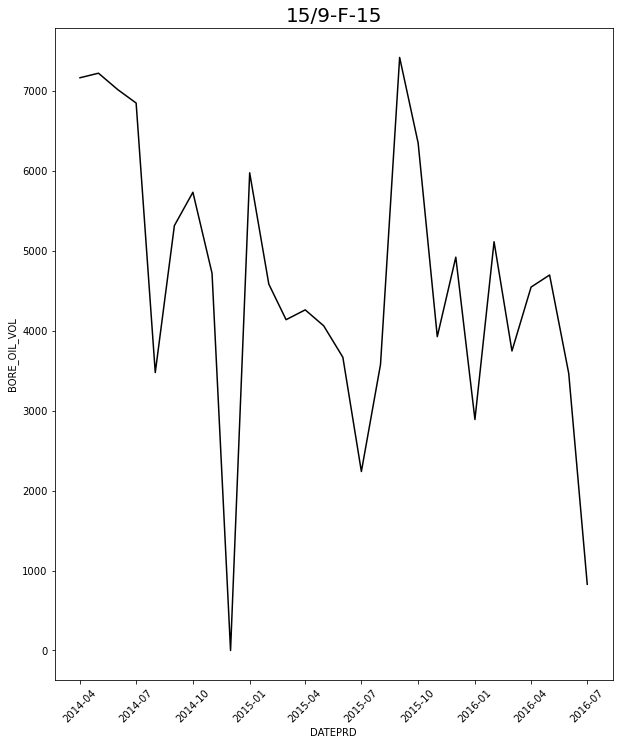

In [131]:
fig_dims = (10, 12)
fig, ax = plt.subplots(figsize=fig_dims)
ax.set_title('15/9-F-15',size=20)
plt.xticks(rotation = 45)
sns.lineplot(x='DATEPRD', y='BORE_OIL_VOL', data=df2, ax=ax, color='black')

Examine dataframe shape.

In [132]:
df2.shape

(28, 12)

Call dataframe head.

In [133]:
df2.head()

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,NPD_WELL_BORE_NAME
DATEPRD,,,,,,,,,,,,
2014-04-01,200.664000,106.575833,155.428800,21.926800,12.084126,45.235233,30.047467,16.099533,7163.0,0.0,0.0,15/9-F-15 D
2014-05-01,198.684452,106.601097,156.117355,19.491419,12.248254,42.567129,32.332774,13.780516,7220.0,0.0,0.0,15/9-F-15 D
2014-06-01,200.628467,106.556000,157.647867,17.958633,11.596296,42.980567,33.801100,14.272233,7016.0,0.0,0.0,15/9-F-15 D
2014-07-01,199.381516,106.608355,157.688000,17.622129,11.544357,41.693419,34.690742,12.902742,6847.0,0.0,0.0,15/9-F-15 D
2014-08-01,225.085129,105.069548,181.484806,11.104000,9.292741,43.600290,26.771290,23.006710,3476.0,0.0,0.0,15/9-F-15 D


Call dataframe tail

In [134]:
df2.tail()

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,NPD_WELL_BORE_NAME
DATEPRD,,,,,,,,,,,,
2016-03-01,218.160839,105.842548,184.348968,16.219032,12.305040,33.811903,37.630516,17.960387,3746.0,0.0,5035.0,15/9-F-15 D
2016-04-01,232.432300,105.733967,197.541600,16.938367,19.377015,34.890833,36.453000,11.502967,4545.0,29.0,5687.0,15/9-F-15 D
2016-05-01,209.717903,106.244226,184.899968,18.447258,16.015713,24.818000,42.118097,7.889194,4696.0,0.0,6007.0,15/9-F-15 D
2016-06-01,212.926967,105.923067,184.994100,16.132400,23.024772,27.932900,40.764933,14.086767,3466.0,0.0,5390.0,15/9-F-15 D
2016-07-01,308.101258,92.706710,299.597355,4.271226,7.057121,8.503903,12.570806,9.004000,828.0,0.0,1173.0,15/9-F-15 D


 <b>4.5.1 Auto-ARIMA<b/> <a class="anchor" id="20"></a>

Create oil production rate time series

In [135]:
df2_Oil = df2['BORE_OIL_VOL']

Call time series tail

In [136]:
df2_Oil.tail()

DATEPRD
2016-03-01    3746.0
2016-04-01    4545.0
2016-05-01    4696.0
2016-06-01    3466.0
2016-07-01     828.0
Name: BORE_OIL_VOL, dtype: float64

Split time series between Training and Testing

In [137]:
Train=df2_Oil.loc[:'2016-03-01']

In [138]:
Test=df2_Oil.loc['2016-04-01':]

In [139]:
Test

DATEPRD
2016-04-01    4545.0
2016-05-01    4696.0
2016-06-01    3466.0
2016-07-01     828.0
Name: BORE_OIL_VOL, dtype: float64

Plot train set.

<AxesSubplot:xlabel='DATEPRD'>

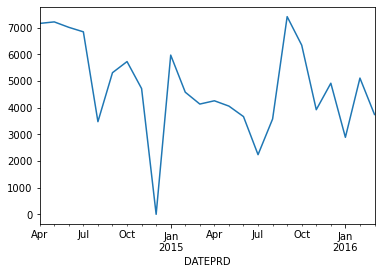

In [140]:
Train.plot() 

Plot test set.

<AxesSubplot:xlabel='DATEPRD'>

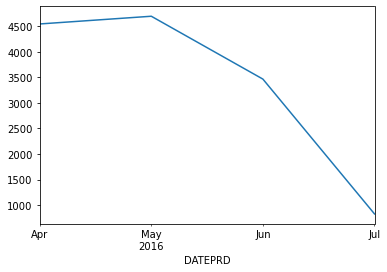

In [141]:
Test.plot()

Create auto arima object. This model will auto-select the best model given our p , q , d space and select the model with the lowest AIC score.

In [142]:
arima_model = auto_arima(Train, X=None, start_p=1, d=None, start_q=1, max_p=5, max_d=4, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None)

Print summary of auto-ARIMA model

In [143]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:                        SARIMAX   Log Likelihood                -213.250
Date:                Thu, 07 Apr 2022   AIC                            430.499
Time:                        22:28:40   BIC                            432.856
Sample:                             0   HQIC                           431.124
                                 - 24                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4763.9167    377.331     12.625      0.000    4024.362    5503.472
sigma2      3.057e+06   8.62e+05      3.545      0.000    1.37e+06    4.75e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.35   Prob(JB):                         0.58
Heteroskedasticity (H):               0.68   Skew:                            -0.50
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best Auto-ARIMA model does not have the same p,d,q as the auto-ARIMA model.

Create Summary dataframe

In [144]:
Summary =pd.DataFrame(Test)

Call summary dataframe

In [145]:
Summary

,BORE_OIL_VOL
DATEPRD,
2016-04-01,4545.0
2016-05-01,4696.0
2016-06-01,3466.0
2016-07-01,828.0


Add auto-ARIMA predictions for the next 4 months to the Summary dataframe.

In [146]:
Summary['Auto-ARIMA'] =pd.DataFrame(arima_model.predict(n_periods=4),index=Test.index)

Call summary dataframe

In [147]:
Summary

,BORE_OIL_VOL,Auto-ARIMA
DATEPRD,,
2016-04-01,4545.0,4763.916667
2016-05-01,4696.0,4763.916667
2016-06-01,3466.0,4763.916667
2016-07-01,828.0,4763.916667


 <b>4.5.2 KATS<b/> <a class="anchor" id="21"></a>

KATS which stands for Kits to Analyze Time Series is a light-weight,easy-to-use,extenable, and generalizable framework to perform time series analysis in Python. It supports forecasting, detection, feature extractionand useful utilites such as time series simulators. KATS supports the following 10 forecasting models Linear, Quadratic, ARIMA, SARIMA, Holt-Winters, Prophet, AR-Net, LSTM, Theta and VAR.

 <b>4.4.2.1 KATS - ARIMA<b/> <a class="anchor" id="22"></a>

KATS has an ARIMA implementation and we will use this as our first model.

Call shape of dataframe

In [148]:
df2.shape

(28, 12)

Create training set by removing last 4 months of data

In [149]:
df2_train = df2.loc[:'2016-03-01'].copy()

Call shape of dataframe

In [150]:
df2_train.shape

(24, 12)

Call shape of dataframe

In [151]:
df2_train.shape

(24, 12)

Call head of dataframe

In [152]:
df2_train.head()

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,NPD_WELL_BORE_NAME
DATEPRD,,,,,,,,,,,,
2014-04-01,200.664000,106.575833,155.428800,21.926800,12.084126,45.235233,30.047467,16.099533,7163.0,0.0,0.0,15/9-F-15 D
2014-05-01,198.684452,106.601097,156.117355,19.491419,12.248254,42.567129,32.332774,13.780516,7220.0,0.0,0.0,15/9-F-15 D
2014-06-01,200.628467,106.556000,157.647867,17.958633,11.596296,42.980567,33.801100,14.272233,7016.0,0.0,0.0,15/9-F-15 D
2014-07-01,199.381516,106.608355,157.688000,17.622129,11.544357,41.693419,34.690742,12.902742,6847.0,0.0,0.0,15/9-F-15 D
2014-08-01,225.085129,105.069548,181.484806,11.104000,9.292741,43.600290,26.771290,23.006710,3476.0,0.0,0.0,15/9-F-15 D


Drop 'NPD_WELL_BORE_NAME' column.

In [153]:
df2_train.drop(columns=['NPD_WELL_BORE_NAME'],inplace=True)

Create TimeSeriesData object by assigning index as time value and oil production rate as value.

In [154]:
DF2 =TimeSeriesData(time=df2_train.index,value=df2_train['BORE_OIL_VOL'])

Create SARIMA param class

In [155]:
params = SARIMAParams(
    p = 3, 
    d=1, 
    q=0, 
    )

Initiate SARIMA model

In [156]:
m = SARIMAModel(data=DF2, params=params)

Fit SARIMA model

In [157]:
m.fit()

Generate Forecast values

In [158]:
fcst = m.predict(
    steps=4, 
    freq="MS"
    )

Print Forecast values

In [159]:
fcst

,time,fcst,fcst_lower,fcst_upper
24,2016-04-01,4065.586544,296.050577,7835.122512
25,2016-05-01,3912.931790,-245.380540,8071.244119
26,2016-06-01,4193.138710,-166.755598,8553.033017
27,2016-07-01,4028.389034,-568.481920,8625.259989


Save Forecast values to Summary dataframe

In [160]:
Summary['KATS-ARIMAX'] =list(fcst['fcst'])

Print Forecast values

In [161]:
fcst

,time,fcst,fcst_lower,fcst_upper
24,2016-04-01,4065.586544,296.050577,7835.122512
25,2016-05-01,3912.931790,-245.380540,8071.244119
26,2016-06-01,4193.138710,-166.755598,8553.033017
27,2016-07-01,4028.389034,-568.481920,8625.259989


Print Summary dataframe

In [162]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX
DATEPRD,,,
2016-04-01,4545.0,4763.916667,4065.586544
2016-05-01,4696.0,4763.916667,3912.931790
2016-06-01,3466.0,4763.916667,4193.138710
2016-07-01,828.0,4763.916667,4028.389034


<b>4.5.2.2 KATS - fbProphet<b/> <a class="anchor" id="23"></a>

Create Prophetparams class model

In [163]:
params = ProphetParams(growth='linear')

Create a prophet model instance

In [164]:
m = ProphetModel(DF2, params)

Fit fbProphet model

In [165]:
m.fit()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


In [166]:
fcst = m.predict(
    steps=4, 
    freq="MS"
    )

Print Forecast values

In [167]:
fcst

,time,fcst,fcst_lower,fcst_upper
0,2016-04-01,3666.830770,1475.691590,5817.982903
1,2016-05-01,3580.221993,1498.353897,5570.188286
2,2016-06-01,3490.726258,1516.545438,5636.688332
3,2016-07-01,3404.117482,1319.554194,5654.550837


Save Forecast values to Summary dataframe

In [168]:
Summary['KATS-fbProphet'] =list(fcst['fcst'])

Print Summary dataframe

In [169]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX,KATS-fbProphet
DATEPRD,,,,
2016-04-01,4545.0,4763.916667,4065.586544,3666.830770
2016-05-01,4696.0,4763.916667,3912.931790,3580.221993
2016-06-01,3466.0,4763.916667,4193.138710,3490.726258
2016-07-01,828.0,4763.916667,4028.389034,3404.117482


Plot timeseries training set and predictions

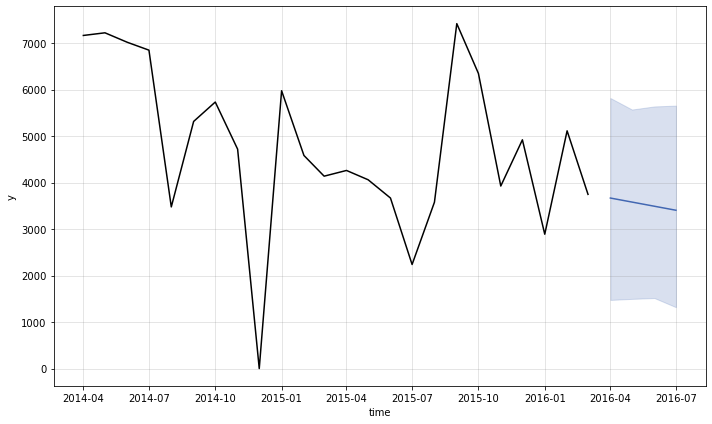

In [170]:
m.plot()

<b>4.5.2.3 KATS - Theta model<b/> <a class="anchor" id="24"></a>

The theta model is a simple exponential smoothing model with drift.

Create Thetaparams class model

In [171]:
params = ThetaParams()

Create a Theta model instance

In [172]:
m = ThetaModel(data=DF2, params=params)

Fit Theta model

In [173]:
m.fit()

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\kats\models\theta.py:121: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



Generate Forecast values

In [174]:
fcst = m.predict(
    steps=4, 
    freq="MS"
    )

Print Forecast values

In [175]:
fcst

,time,fcst,fcst_lower,fcst_upper
24,2016-04-01,4130.117702,474.959583,7785.275821
25,2016-05-01,4086.002049,248.853446,7923.150653
26,2016-06-01,4041.886397,30.996480,8052.776315
27,2016-07-01,3997.770745,-179.640709,8175.182200


Save Forecast values to Summary dataframe

In [176]:
Summary['KATS-Theta'] =list(fcst['fcst'])

Print Summary dataframe

In [177]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX,KATS-fbProphet,KATS-Theta
DATEPRD,,,,,
2016-04-01,4545.0,4763.916667,4065.586544,3666.830770,4130.117702
2016-05-01,4696.0,4763.916667,3912.931790,3580.221993,4086.002049
2016-06-01,3466.0,4763.916667,4193.138710,3490.726258,4041.886397
2016-07-01,828.0,4763.916667,4028.389034,3404.117482,3997.770745


Plot timeseries training set and predictions

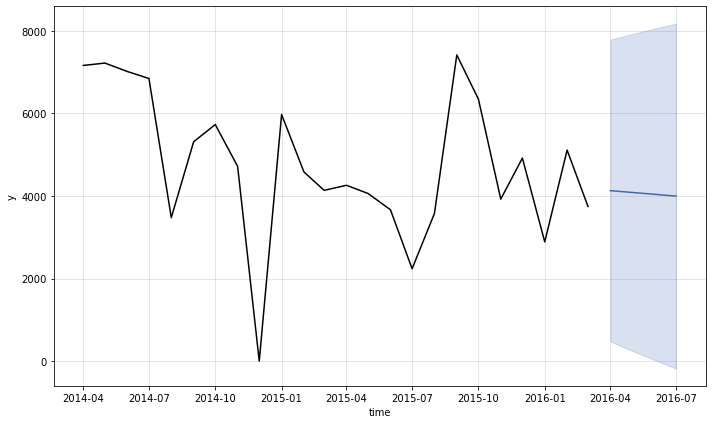

In [178]:
m.plot()

<b>4.5.2.4 KATS - Harmonic Regression model<b/> <a class="anchor" id="25"></a>

Harmonic regression is linear regression with sinusoidal functions to characterize seasonality in a time series.

Create HarmonicRegressionModelParams class model

In [179]:
params = QuadraticModelParams()

Create a Quadratic model instance

In [180]:
m = QuadraticModel(data=DF2, params=params)

Fit Quadratic Model

In [181]:
m.fit()

Generate Forecast values

In [182]:
fcst = m.predict(
    steps=4, 
    freq="MS"
    )

Print Forecast values

In [183]:
fcst

,time,fcst,fcst_lower,fcst_upper
0,2016-04-01,5270.934783,1235.007171,9306.862394
1,2016-05-01,5569.081739,1307.019882,9831.143596
2,2016-06-01,5896.950100,1361.027946,10432.872255
3,2016-07-01,6254.539866,1396.214400,11112.865333


Save Forecast values to Summary dataframe

In [184]:
Summary['KATS-Quadratic'] =list(fcst['fcst'])

Print Summary dataframe

In [185]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX,KATS-fbProphet,KATS-Theta,KATS-Quadratic
DATEPRD,,,,,,
2016-04-01,4545.0,4763.916667,4065.586544,3666.830770,4130.117702,5270.934783
2016-05-01,4696.0,4763.916667,3912.931790,3580.221993,4086.002049,5569.081739
2016-06-01,3466.0,4763.916667,4193.138710,3490.726258,4041.886397,5896.950100
2016-07-01,828.0,4763.916667,4028.389034,3404.117482,3997.770745,6254.539866


Plot timeseries training set and predictions

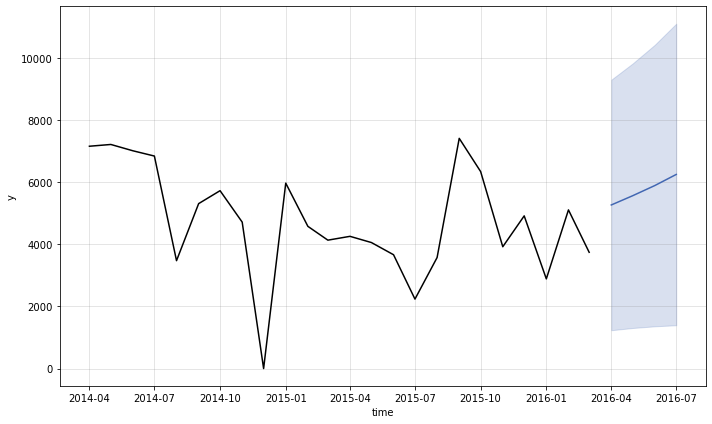

In [186]:
m.plot()

<b>4.5.2.5 KATS - LSTM model<b/> <a class="anchor" id="26"></a>

The LSTM model stands for Long short-term memory, it is a recurrent neural network model that can be used for sequential data.

Create LSTMParams class model

In [187]:
params = LSTMParams(hidden_size=3,time_window=5,num_epochs = 1000)

Create an LSTM model instance

In [188]:
m = LSTMModel(data=DF2, params=params)

Fit LSTM model

In [189]:
m.fit()

Generate Forecast values

In [190]:
fcst = m.predict(
    steps=4, 
    freq="MS"
    )

Print Forecast values

In [191]:
fcst

,time,fcst,fcst_lower,fcst_upper
0,2016-04-01,1778.806858,1689.866515,1867.747201
1,2016-05-01,3411.531600,3240.955020,3582.108180
2,2016-06-01,6012.370824,5711.752283,6312.989365
3,2016-07-01,3851.997230,3659.397369,4044.597092


Save Forecast values to Summary dataframe

In [192]:
Summary['KATS-LSTM'] =list(fcst['fcst'])

Print Summary dataframe

In [193]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX,KATS-fbProphet,KATS-Theta,KATS-Quadratic,KATS-LSTM
DATEPRD,,,,,,,
2016-04-01,4545.0,4763.916667,4065.586544,3666.830770,4130.117702,5270.934783,1778.806858
2016-05-01,4696.0,4763.916667,3912.931790,3580.221993,4086.002049,5569.081739,3411.531600
2016-06-01,3466.0,4763.916667,4193.138710,3490.726258,4041.886397,5896.950100,6012.370824
2016-07-01,828.0,4763.916667,4028.389034,3404.117482,3997.770745,6254.539866,3851.997230


<b>4.5.2.6 KATS - Ensemble model<b/> <a class="anchor" id="27"></a>

The ensemble model in KATS allows us to aggregate different models in KATS. In this model we will combine the prophet, linear, quadratic and theta models and find the median of the models as a forecast.

Define the parameters for each individual forecasting model in 'EnsembleParams' class.

In [194]:
model_params = EnsembleParams(
            [
                                
                BaseModelParams("prophet", prophet.ProphetParams()),  # requires fbprophet be installed
                BaseModelParams("linear", linear_model.LinearModelParams()),
                BaseModelParams("quadratic", quadratic_model.QuadraticModelParams()),
                BaseModelParams("theta", theta.ThetaParams(m=12)),
            ]
        )

Create KatsEnsembleParam with detailed configurations

In [195]:
KatsEnsembleParam = {
    "models": model_params,
    "aggregation": "median",
    "seasonality_length": 0,
    "decomposition_method": "multiplicative",
    
}

Create KatsEnsemble model

In [196]:
m = KatsEnsemble(
    data=DF1, 
    params=KatsEnsembleParam
    )

Fit model

In [197]:
m.fit()

Generate Forecast values

In [198]:
fcst = m.predict(steps=4)

Aggregate individual model results

In [199]:
m.aggregate()

,time,fcst,fcst_lower,fcst_upper
0,2016-04-01,2311.040303,-4078.112516,8700.193123
1,2016-05-01,2925.651911,-4449.992040,10301.295862
2,2016-06-01,2285.047486,-5148.059295,8012.180314
3,2016-07-01,1819.524261,-5695.140451,7694.047188


Save Forecast values to Summary dataframe

In [200]:
Summary['KATS-Ensemble'] =list(m.aggregate()['fcst'])

Print Summary dataframe

In [201]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX,KATS-fbProphet,KATS-Theta,KATS-Quadratic,KATS-LSTM,KATS-Ensemble
DATEPRD,,,,,,,,
2016-04-01,4545.0,4763.916667,4065.586544,3666.830770,4130.117702,5270.934783,1778.806858,2311.040303
2016-05-01,4696.0,4763.916667,3912.931790,3580.221993,4086.002049,5569.081739,3411.531600,2925.651911
2016-06-01,3466.0,4763.916667,4193.138710,3490.726258,4041.886397,5896.950100,6012.370824,2285.047486
2016-07-01,828.0,4763.916667,4028.389034,3404.117482,3997.770745,6254.539866,3851.997230,1819.524261


<b>4.5.3 SKTIME<b/> <a class="anchor" id="28"></a>

SKTIME offers scikit-learn compatible interfaces and model composition tools. It is an open-source Python toolbox for machine learning with time series. Sktime extends the scikit-learn API to time series tasks.

<b>4.5.3.1 SKTIME-Theta model<b/> <a class="anchor" id="29"></a>

Create timeseries with the datetime index as a column.

In [202]:
df2sktime=df2.reset_index().copy()

Create training data.

In [203]:
Traindf2sktime = df2sktime.loc[:24]

Drop irrelevant columns

In [204]:
Traindf2sktime =Traindf2sktime['BORE_OIL_VOL']

Set series frequency to monthly.

In [205]:
Train.index.freq  = 'MS'

Create an Theta model instance

In [206]:
forecaster=ThetaForecaster(deseasonalize=False)

Fit model

In [207]:
forecaster.fit(Traindf2sktime)

C:\Users\ferna\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



ThetaForecaster(deseasonalize=False)

Generate Forecast values

In [208]:
forecaster.predict(fh=[1,2,3,4])

25    3890.135997
26    3850.100228
27    3810.064458
28    3770.028689
dtype: float64

Save Forecast values to Summary dataframe

In [209]:
Summary['SKTIME-ThetaForecaster'] = list(forecaster.predict(fh=[1,2,3,4]))

Print Summary dataframe

In [210]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX,KATS-fbProphet,KATS-Theta,KATS-Quadratic,KATS-LSTM,KATS-Ensemble,SKTIME-ThetaForecaster
DATEPRD,,,,,,,,,
2016-04-01,4545.0,4763.916667,4065.586544,3666.830770,4130.117702,5270.934783,1778.806858,2311.040303,3890.135997
2016-05-01,4696.0,4763.916667,3912.931790,3580.221993,4086.002049,5569.081739,3411.531600,2925.651911,3850.100228
2016-06-01,3466.0,4763.916667,4193.138710,3490.726258,4041.886397,5896.950100,6012.370824,2285.047486,3810.064458
2016-07-01,828.0,4763.916667,4028.389034,3404.117482,3997.770745,6254.539866,3851.997230,1819.524261,3770.028689


<b>4.5.3.2 SKTIME-TBATS<b/> <a class="anchor" id="30"></a>

TBATS stands for "Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal components" takes it root in exponential smooting methods.

Create an TBATS model instance

In [211]:
forecaster= TBATS()

Fit TBATS model

In [212]:
forecaster.fit(Traindf2sktime)

TBATS()

Generate Forecast values

In [213]:
forecaster.predict(fh=[1,2,3,4])

25    4474.831904
26    4468.156146
27    4462.777531
28    4458.444017
Name: BORE_OIL_VOL, dtype: float64

Save Forecast values to Summary dataframe

In [214]:
Summary['SKTIME-TBATS'] = list(forecaster.predict(fh=[1,2,3,4]))

<b>4.5.3.3 SKTIME-Polynomial Trend<b/> <a class="anchor" id="31"></a>

Polynomial Trend Forecaster, forecast time series with a polynomial trend.

In [215]:
forecaster = PolynomialTrendForecaster(degree=2)

Fit Polynomial Trend model

In [216]:
forecaster.fit(Traindf2sktime)

PolynomialTrendForecaster(degree=2)

Generate Forecast values

In [217]:
forecaster.predict(fh=[1,2,3,4])

25    5307.745217
26    5595.407960
27    5910.310279
28    6252.452174
dtype: float64

Save Forecast values to Summary dataframe

In [218]:
Summary['SKTIME-PolynomialTrend'] = list(forecaster.predict(fh=[1,2,3,4]))

Print Summary dataframe

In [219]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX,KATS-fbProphet,KATS-Theta,KATS-Quadratic,KATS-LSTM,KATS-Ensemble,SKTIME-ThetaForecaster,SKTIME-TBATS,SKTIME-PolynomialTrend
DATEPRD,,,,,,,,,,,
2016-04-01,4545.0,4763.916667,4065.586544,3666.830770,4130.117702,5270.934783,1778.806858,2311.040303,3890.135997,4474.831904,5307.745217
2016-05-01,4696.0,4763.916667,3912.931790,3580.221993,4086.002049,5569.081739,3411.531600,2925.651911,3850.100228,4468.156146,5595.407960
2016-06-01,3466.0,4763.916667,4193.138710,3490.726258,4041.886397,5896.950100,6012.370824,2285.047486,3810.064458,4462.777531,5910.310279
2016-07-01,828.0,4763.916667,4028.389034,3404.117482,3997.770745,6254.539866,3851.997230,1819.524261,3770.028689,4458.444017,6252.452174


<b>4.5.4 Silverkite <b/> <a class="anchor" id="32"></a>

The Silverkite algorithm is part of the Greykite package. Silverkite, is highly customizable, with tuning parameters to capture diverse time series characterics. The output is interpretable, allowing visualizations of the trend, seasonality, and other effects, along with their statistical significance.

Create training data for silverkite

In [220]:
TrainSilverkite = df2sktime.iloc[:24].copy()

Specify dataset information

In [221]:
 metadata = MetadataParam(
     time_col="DATEPRD",  
     value_col="BORE_OIL_VOL",  
     freq="MS" 
 )

Create a Silverkite model instance

In [222]:
forecaster = Forecaster()

Fit Silverkite model

In [223]:
result = forecaster.run_forecast_config(
            df=TrainSilverkite,
            config=ForecastConfig(
                forecast_horizon=4,  
                coverage=0.99,  
                metadata_param=metadata
                                )
                                       )

Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\greykite\algo\forecast\silverkite\forecast_simple_silverkite_helper.py:130: UserWarning:

Requested holiday 'Easter Monday [England, Wales, Northern Ireland]' does not occur in the provided countries

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\greykite\algo\forecast\silverkite\forecast_silverkite.py:2560: UserWarning:

The granularity of data is larger than daily. Ensure the daily events data match the timestamps

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedM

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedM

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedM

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\greykite\algo\forecast\silverkite\forecast_silverkite.py:2560: UserWarning:

The granularity of data is larger than daily. Ensure the daily events data match the timestamps

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\greykite\common\evaluation.py:418: UserWarning:

y_true contains 0. MAPE is undefined.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\greykite\sklearn\sklearn_scorer.py:174: UserWarning:

Score is undefined for this split, setting to `np.nan`.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\greykite\common\evaluation.py:435: UserWarning:

y_true contains 0. MedAPE is undefined.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\greykite\sklearn\sklearn_scorer.py:174: UserWarning:

Score is undefined for this split, setting to `np.nan`.

C:\Users\ferna\anaconda3\envs\timeseries\lib\site-packages\greykite\algo\forecast\silverkite\forecast_silverkite.py:2560: UserWarni

Save forecast.

In [224]:
forecast = result.forecast

Save Forecast values to Summary dataframe

In [225]:
Summary['Silverkite'] =list(forecast.df.tail(4).round(2)['forecast'])

Print Summary dataframe

In [226]:
Summary

,BORE_OIL_VOL,Auto-ARIMA,KATS-ARIMAX,KATS-fbProphet,KATS-Theta,KATS-Quadratic,KATS-LSTM,KATS-Ensemble,SKTIME-ThetaForecaster,SKTIME-TBATS,SKTIME-PolynomialTrend,Silverkite
DATEPRD,,,,,,,,,,,,
2016-04-01,4545.0,4763.916667,4065.586544,3666.830770,4130.117702,5270.934783,1778.806858,2311.040303,3890.135997,4474.831904,5307.745217,4763.81
2016-05-01,4696.0,4763.916667,3912.931790,3580.221993,4086.002049,5569.081739,3411.531600,2925.651911,3850.100228,4468.156146,5595.407960,4763.88
2016-06-01,3466.0,4763.916667,4193.138710,3490.726258,4041.886397,5896.950100,6012.370824,2285.047486,3810.064458,4462.777531,5910.310279,4763.78
2016-07-01,828.0,4763.916667,4028.389034,3404.117482,3997.770745,6254.539866,3851.997230,1819.524261,3770.028689,4458.444017,6252.452174,4763.79


Transpose Summary dataframe

In [227]:
Summary.transpose()

DATEPRD,2016-04-01,2016-05-01,2016-06-01,2016-07-01
BORE_OIL_VOL,4545.000000,4696.000000,3466.000000,828.000000
Auto-ARIMA,4763.916667,4763.916667,4763.916667,4763.916667
KATS-ARIMAX,4065.586544,3912.931790,4193.138710,4028.389034
KATS-fbProphet,3666.830770,3580.221993,3490.726258,3404.117482
KATS-Theta,4130.117702,4086.002049,4041.886397,3997.770745
KATS-Quadratic,5270.934783,5569.081739,5896.950100,6254.539866
KATS-LSTM,1778.806858,3411.531600,6012.370824,3851.997230
KATS-Ensemble,2311.040303,2925.651911,2285.047486,1819.524261
SKTIME-ThetaForecaster,3890.135997,3850.100228,3810.064458,3770.028689
SKTIME-TBATS,4474.831904,4468.156146,4462.777531,4458.444017


Create new dataframe Summaryt which is the transposed version of Summary dataframe.

In [228]:
Summaryt=Summary.transpose()

Remove first row of Summaryt

In [229]:
Summaryt = Summaryt.iloc[1:]

Examine Summaryt dataframe.

In [230]:
Summaryt

DATEPRD,2016-04-01,2016-05-01,2016-06-01,2016-07-01
Auto-ARIMA,4763.916667,4763.916667,4763.916667,4763.916667
KATS-ARIMAX,4065.586544,3912.931790,4193.138710,4028.389034
KATS-fbProphet,3666.830770,3580.221993,3490.726258,3404.117482
KATS-Theta,4130.117702,4086.002049,4041.886397,3997.770745
KATS-Quadratic,5270.934783,5569.081739,5896.950100,6254.539866
KATS-LSTM,1778.806858,3411.531600,6012.370824,3851.997230
KATS-Ensemble,2311.040303,2925.651911,2285.047486,1819.524261
SKTIME-ThetaForecaster,3890.135997,3850.100228,3810.064458,3770.028689
SKTIME-TBATS,4474.831904,4468.156146,4462.777531,4458.444017
SKTIME-PolynomialTrend,5307.745217,5595.407960,5910.310279,6252.452174


Create a list of the dates out of Summary.index

In [231]:
Columns = list(Summary.index)

Add "MAPE" column to Columns list.

In [232]:
Columns.append('MAPE')

Create performance dataframe using the Columns list as the columns.

In [233]:
PerformanceA2 = pd.DataFrame(columns=Columns)

Call Performance dataframe

In [234]:
PerformanceA2

,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,MAPE


Create list out of Summary.Columns

In [235]:
Summary_Columns = list(Summary.columns)

Remove 'BORE_OIL_VOL' from list

In [236]:
Summary_Columns.remove('BORE_OIL_VOL')

Call Summary_Columns list

In [237]:
Summary_Columns

['Auto-ARIMA',
 'KATS-ARIMAX',
 'KATS-fbProphet',
 'KATS-Theta',
 'KATS-Quadratic',
 'KATS-LSTM',
 'KATS-Ensemble',
 'SKTIME-ThetaForecaster',
 'SKTIME-TBATS',
 'SKTIME-PolynomialTrend',
 'Silverkite']

Create list out of Model names

In [238]:
Indexes = ['Auto-ARIMA',
 'KATS-ARIMAX',
 'KATS-fbProphet',
 'KATS-Theta',
 'KATS-Quadratic',
 'KATS-LSTM',
 'KATS-Ensemble',
 'SKTIME-ThetaForecaster',
 'SKTIME-TBATS',
 'SKTIME-PolynomialTrend',
 'Silverkite']

Define MAPE function

In [239]:
def mape(y, y_hat):
    return np.mean(np.abs((y - y_hat)/y)*100)

Append Performance dataframe with APE and MAPE for each model.

In [240]:
index=0
for element in range(11):
    PerformanceA2.loc[Indexes[index]] = [mape(Summary.loc['2016-04-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1]),
                                       mape(Summary.loc['2016-05-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1]),
                                       mape(Summary.loc['2016-06-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1]),
                                       mape(Summary.loc['2016-07-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1]),
                                       (mape(Summary.loc['2016-04-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1])+
                                       mape(Summary.loc['2016-05-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1])+
                                       mape(Summary.loc['2016-06-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1])+
                                       mape(Summary.loc['2016-07-01 00:00:00','BORE_OIL_VOL'],Summaryt.iloc[index,1]))/4
                                      ]
    index =index + 1

<b>4.5.5 Performance of Models <b/> <a class="anchor" id="33"></a>

Call Performance dataframe

In [241]:
PerformanceA2

,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,MAPE
Auto-ARIMA,4.816648,1.446266,37.447105,475.352254,129.765569
KATS-ARIMAX,13.906891,16.675217,12.894743,372.576303,104.013289
KATS-fbProphet,21.227239,23.760179,3.295499,332.393961,95.169219
KATS-Theta,10.098965,12.989735,17.888115,393.478508,108.613831
KATS-Quadratic,22.532051,18.592030,60.677488,572.594413,168.598996
KATS-LSTM,24.938799,27.352394,1.571506,312.020725,91.470856
KATS-Ensemble,35.629221,37.699065,15.589962,253.339603,85.564463
SKTIME-ThetaForecaster,15.289324,18.013198,11.081945,364.987950,102.343104
SKTIME-TBATS,1.690734,4.851871,28.913911,439.632385,118.772225
SKTIME-PolynomialTrend,23.111286,19.152640,61.437044,575.773908,169.868720


Save Performance dataframe as CSV

In [242]:
PerformanceA2.to_csv('df2AdvancedPerformance.csv')

 <b>4.6 Summary<b/> <a class="anchor" id="34"></a>

#### Well F - 14 performance

In [243]:
PerformanceA1.reset_index(inplace=True)

In [244]:
PerformanceA1.rename(columns={'index': 'Model'},inplace=True)

In [245]:
PerformanceB1

,Model,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,MAPE
0,AR_order_2_difference_2,13.148332,15.850624,11.989556,103.963873,36.238096
1,AR_order_6_difference_2,21.022414,23.479713,19.968694,85.472249,37.485768
2,MA_order_4_difference_2,54.757805,49.942689,56.822585,263.435749,106.239707
3,ARIMA_p_order_6_difference_2_q_order_0,11.374029,14.131526,10.191580,108.130674,35.956952
4,ARIMAX_p_order_1_difference_2_q_order_1,12.106721,14.841422,10.934048,106.410007,36.073050


In [246]:
PerformanceA1

,Model,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,MAPE
0,Auto-ARIMA,1.510069,4.574472,0.196015,131.295359,34.393979
1,KATS-ARIMAX,19.059558,15.355154,20.648052,179.601406,58.666043
2,KATS-fbProphet,220.715370,210.736671,224.994358,653.173199,327.404899
3,KATS-Theta,5.773030,2.482021,7.184255,148.399106,40.959603
4,KATS-Quadratic,17.869888,20.425275,16.774107,92.875692,36.986241
5,KATS-LSTM,26.112678,28.411599,25.126873,73.518190,38.292335
6,KATS-Ensemble,6.048429,8.971627,4.794926,120.637399,35.113095
7,SKTIME-ThetaForecaster,0.747198,3.835338,0.577034,133.086896,34.561616
8,SKTIME-TBATS,23.689575,19.841113,25.339843,190.474613,64.836286
9,SKTIME-PolynomialTrend,11.910353,14.651163,10.735060,106.871162,36.041935


#### Well F - 15 performance

In [247]:
PerformanceA2.reset_index(inplace=True)

In [248]:
PerformanceA2.rename(columns={'index': 'Model'},inplace=True)

In [249]:
PerformanceB2

,Model,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,MAPE
0,AR_order_2_difference_2,4.461194,1.102241,36.980994,473.401118,128.986387
1,AR_order_0_difference_0,0.170149,3.380181,30.907868,447.979071,120.609317
2,MA_order_1_difference_0,4.816648,1.446266,37.447105,475.352255,129.765569
3,MA_order_3_difference_0,4.212378,0.861426,36.654719,472.035334,128.440964
4,ARIMA_p_order_0_difference_0_q_order_2,66.759857,67.828695,56.411873,82.459479,68.364976
5,ARIMAX_p_order_0_difference_0_q_order_2,67.440455,68.487408,57.304347,78.723592,67.988950


In [250]:
PerformanceA2

,Model,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,MAPE
0,Auto-ARIMA,4.816648,1.446266,37.447105,475.352254,129.765569
1,KATS-ARIMAX,13.906891,16.675217,12.894743,372.576303,104.013289
2,KATS-fbProphet,21.227239,23.760179,3.295499,332.393961,95.169219
3,KATS-Theta,10.098965,12.989735,17.888115,393.478508,108.613831
4,KATS-Quadratic,22.532051,18.592030,60.677488,572.594413,168.598996
5,KATS-LSTM,24.938799,27.352394,1.571506,312.020725,91.470856
6,KATS-Ensemble,35.629221,37.699065,15.589962,253.339603,85.564463
7,SKTIME-ThetaForecaster,15.289324,18.013198,11.081945,364.987950,102.343104
8,SKTIME-TBATS,1.690734,4.851871,28.913911,439.632385,118.772225
9,SKTIME-PolynomialTrend,23.111286,19.152640,61.437044,575.773908,169.868720


  For the F-14 well the Auto- ARIMA model has the lowest MAPE value compared to every other model (although the Auto - ARIMA model has a different p, q and d vs the best ARIMA model). The other advanced models did not perform any better than classical models. The poor performance of the models is due to the fact the last month has a significantly lower oil production than the first 3 months of the test set which throws off the value of the APE for that month.
  The F-15 well on the other hand does not follow a typical decline curve as can be seen with the shape of the curve being all over the place. Just like the F-14 well the ARIMA (in this case with the exogeneoue variables) performed significantly better than the advanced models, reiterating the importance of classical forecasting algorithms even though advanced algorithms are available. In the next notebook we will attempt the MAPE for both wells further using deep learning methods. 